# Lab. 3: Momentum I

In this lab we will explore the signal research proccess with the classic Jegadeesh and Titman momentum signal.

We will explore:
- How to compute signals with point in time compliance in mind.
- The need to filter out low priced securities.
- How to create decile and spread portfolios.
- Strategy performance metrics.

## Imports

In [35]:
import sf_quant.data as sfd
import polars as pl
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data

We will be looking at our investment universe from 1996 to 2024.

This should take around 10 seconds to run.

In [36]:
start = dt.date(1996, 1, 1)
end = dt.date(2024, 12, 31)

columns = [
    'date',
    'barrid',
    'ticker',
    'price',
    'return',
    'market_cap'
]

data = sfd.load_assets(
    start=start,
    end=end,
    in_universe=True,
    columns=columns
)

data

date,barrid,ticker,price,return,market_cap
date,str,str,f64,f64,f64
2013-07-31,"""USA06Z1""","""MDXG""",6.26,-0.1595,6.006157e8
2013-08-01,"""USA06Z1""","""MDXG""",6.32,0.9585,6.0865392e8
2013-08-02,"""USA06Z1""","""MDXG""",6.31,-0.1582,6.0769086e8
2013-08-05,"""USA06Z1""","""MDXG""",6.45,2.2187,6.211737e8
2013-08-06,"""USA06Z1""","""MDXG""",6.29,-2.4806,6.0576474e8
…,…,…,…,…,…
2024-12-24,"""USBQOR1""","""ECG""",70.58,2.5872,3.5976e9
2024-12-26,"""USBQOR1""","""ECG""",73.61,4.293,3.7521e9
2024-12-27,"""USBQOR1""","""ECG""",69.85,-5.108,3.5604e9


## Compute the Momentum Signal

## Instructions

- Compute momentum for each security and date as the rolling 230 day return (you can just use log returns here).
- Shift the momentum signal 22 days. This will results in the 11 month return from t-12 to t-2.

In [37]:
def task_compute_momentum(data: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the t_12 to t_2 momentum signal for each secrutiy and date combination.
    
    Args:
        data (pl.DataFrame): Data frame containing date, barrid, price, and return columns.
    
    Returns:
        pl.DataFrame: Data frame with columns date, barrid, price, return, and momentum columns.
    """
    
    momentum = data.sort('barrid', 'date').with_columns(
        pl.col('return').shift(22).rolling_sum(window_size=230).alias('momentum')
    ).filter(
        pl.col('date') >= dt.date(1997, 1, 1)
    )
    return momentum

momentum = task_compute_momentum(data)

momentum

date,barrid,ticker,price,return,market_cap,momentum
date,str,str,f64,f64,f64,f64
2013-07-31,"""USA06Z1""","""MDXG""",6.26,-0.1595,6.006157e8,null
2013-08-01,"""USA06Z1""","""MDXG""",6.32,0.9585,6.0865392e8,null
2013-08-02,"""USA06Z1""","""MDXG""",6.31,-0.1582,6.0769086e8,null
2013-08-05,"""USA06Z1""","""MDXG""",6.45,2.2187,6.211737e8,null
2013-08-06,"""USA06Z1""","""MDXG""",6.29,-2.4806,6.0576474e8,null
…,…,…,…,…,…,…
2024-12-24,"""USBQOR1""","""ECG""",70.58,2.5872,3.5976e9,-0.7863
2024-12-26,"""USBQOR1""","""ECG""",73.61,4.293,3.7521e9,6.0288
2024-12-27,"""USBQOR1""","""ECG""",69.85,-5.108,3.5604e9,0.1688


## Price and Momentum Filter

When doing backtesting strategies it's helpful to drop securities with a price below $5.

- Create a variable price_lag that is the previous days price for each security.
- Filter securities to ones with a lagged price greater than 5.
- Drop null momentum values since we won't trade securities where we don't have a signal.

In [38]:
def task_price_filter(momentum: pl.DataFrame) -> pl.DataFrame:
    """
    Filter the universe to lagged price greater than 5 and non-null momentum.
    
    Args:
        momentum (pl.DataFrame): Data frame with columns date, barrid, price, return, and momentum columns.
    
    Returns:
        pl.DataFrame: Data frame with columns date, barrid, price, return, and momentum columns.
    """
    price_filter = momentum.filter(
        (pl.col('price') > 5) & pl.col('momentum').is_not_null()
    )
    return price_filter

price_filter = task_price_filter(momentum)

price_filter

date,barrid,ticker,price,return,market_cap,momentum
date,str,str,f64,f64,f64,f64
2014-07-30,"""USA06Z1""","""MDXG""",7.1,0.9957,7.410696e8,34.1191
2014-07-31,"""USA06Z1""","""MDXG""",6.91,-2.6761,7.2123816e8,36.44
2014-08-01,"""USA06Z1""","""MDXG""",6.81,-1.4472,7.1080056e8,40.8412
2014-08-04,"""USA06Z1""","""MDXG""",7.08,3.9648,7.3898208e8,40.0623
2014-08-05,"""USA06Z1""","""MDXG""",7.05,-0.4237,7.358508e8,38.3841
…,…,…,…,…,…,…
2024-12-24,"""USBQOR1""","""ECG""",70.58,2.5872,3.5976e9,-0.7863
2024-12-26,"""USBQOR1""","""ECG""",73.61,4.293,3.7521e9,6.0288
2024-12-27,"""USBQOR1""","""ECG""",69.85,-5.108,3.5604e9,0.1688


## Create Decile Portfolios

### Instructions

- For each date divide all securities into 10 deciles based on their momentum score. The highest momentum securities should be in bin 9 and the lowest momentum securities should be in bin 0. The `.qcut()` expression will be helpful here.


In [39]:
def task_momentum_bins(price_filter: pl.DataFrame) -> pl.DataFrame:
    """
    Bin the securities into deciles for each date by momentum.
    
    Args:
        price_filter (pl.DataFrame): Data frame with columns date, barrid, price, return, and momentum columns.
    
    Returns:
        pl.DataFrame: Data frame with columns date, barrid, price, return, momentum and bin columns.
    """
    return price_filter.with_columns(
        pl.col('momentum').qcut(10,labels=[f"p_{i}" for i in range(1, 11)]).alias('bin').over('date')
    )

momentum_bins = task_momentum_bins(price_filter)

momentum_bins

date,barrid,ticker,price,return,market_cap,momentum,bin
date,str,str,f64,f64,f64,f64,cat
2014-07-30,"""USA06Z1""","""MDXG""",7.1,0.9957,7.410696e8,34.1191,"""p_8"""
2014-07-31,"""USA06Z1""","""MDXG""",6.91,-2.6761,7.2123816e8,36.44,"""p_8"""
2014-08-01,"""USA06Z1""","""MDXG""",6.81,-1.4472,7.1080056e8,40.8412,"""p_9"""
2014-08-04,"""USA06Z1""","""MDXG""",7.08,3.9648,7.3898208e8,40.0623,"""p_9"""
2014-08-05,"""USA06Z1""","""MDXG""",7.05,-0.4237,7.358508e8,38.3841,"""p_9"""
…,…,…,…,…,…,…,…
2024-12-24,"""USBQOR1""","""ECG""",70.58,2.5872,3.5976e9,-0.7863,"""p_3"""
2024-12-26,"""USBQOR1""","""ECG""",73.61,4.293,3.7521e9,6.0288,"""p_4"""
2024-12-27,"""USBQOR1""","""ECG""",69.85,-5.108,3.5604e9,0.1688,"""p_3"""


## Equal Weight Portfolios

For each date and bin combo compute the equal weight return.

### Instructions
- Use `.group_by()` to find the average return for each decile on each date.
- Pivot the data frame into index=date, columns=bins, and values=returns (`.pivot()`)
- Compute the spread portfolio as the return of bin 9 minus the return of bin 0

In [40]:
def task_equal_weight_portfolios(momentum_bins: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the equal weight return for each bin on each date.
    
    Args:
        momentum_bins (pl.DataFrame): Data frame with columns date, barrid, price, return, momentum, and bin columns.
    
    Returns:
        pl.DataFrame: Data frame with date as the index, bins as the columns, and returns as the values.
    """
    
    momentum_portfolios = momentum_bins.group_by(['date', 'bin']).agg(
        pl.col('return').mean().alias('ew_return')
    ).pivot(index='date', on='bin', values='ew_return')
    # Add spread portfolio (p_10 minus p_1)
    momentum_portfolios = momentum_portfolios.with_columns(
        (pl.col('p_1') - pl.col('p_10')).alias('spread')
    )
    return momentum_portfolios


momentum_portfolios = task_equal_weight_portfolios(momentum_bins)

momentum_portfolios

date,p_5,p_10,p_9,p_6,p_4,p_2,p_1,p_3,p_8,p_7,spread
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2017-08-16,0.223754,-0.154779,0.104447,0.087399,0.056644,0.055279,0.080652,0.226666,0.005696,0.064488,0.23543
1997-07-25,-0.015105,-0.124046,0.096628,0.208535,0.056588,0.362298,0.107228,-0.341879,0.181139,0.049832,0.231274
2006-01-03,1.254378,2.67213,1.899317,1.233716,1.190826,1.147648,1.048569,1.072422,1.092762,1.193974,-1.623562
2000-01-06,0.869805,-2.899652,-0.574702,0.766243,0.976665,0.791329,0.464267,0.450219,0.023559,0.36082,3.363919
2010-07-28,-1.329537,-1.500205,-1.424258,-1.376116,-1.319654,-1.358175,-1.845615,-1.492304,-1.288396,-1.233362,-0.345411
…,…,…,…,…,…,…,…,…,…,…,…
2024-01-12,-0.131247,-0.138032,0.073915,-0.12813,-0.195742,-0.461657,-0.685081,-0.245332,-0.07943,-0.088687,-0.547049
2010-07-09,1.104797,2.294056,1.539615,1.061138,1.031075,1.152942,1.54242,1.238808,1.313941,1.220003,-0.751636
2010-05-11,0.756188,0.731628,0.705877,0.496542,0.535178,0.540433,0.720469,0.672875,0.702204,0.616666,-0.011159


## Portfolio Returns

Compute the cumulative returns of each bin.

### Instructions
- Use the `.unpivot()` method to put our data frame back into long format.
- Compute the cumulative log return.
- Put the return columns into percent space by multiplying by 100.

In [41]:
def task_cumulative_returns(momentum_portfolios: pl.DataFrame) -> pl.DataFrame:
    """
    Compute the equal weight return for each bin on each date.
    
    Args:
        momentum_portfolios (pl.DataFrame): Data frame with columns date, barrid, price, return, momentum, and bin columns.
    
    Returns:
        pl.DataFrame: Data frame with date, bin, return, and cumulative_log_return columns.
    """
    momentum_returns = momentum_portfolios.melt(
        id_vars='date', 
        variable_name='bin', 
        value_name='return'
    )
    
    # Step 2: Sort values to ensure the cumulative sum is chronological for each bin.
    momentum_returns = momentum_returns.sort(['bin', 'date'])   
    momentum_returns = momentum_returns.with_columns(
        pl.col('return').truediv(100).log1p().cum_sum().over('bin').alias('cumulative_log_return')*100
    )
    return momentum_returns

momentum_returns = task_cumulative_returns(momentum_portfolios)

momentum_returns

/tmp/ipykernel_1027447/3397573524.py:11: DeprecationWarning: `DataFrame.melt` is deprecated; use `DataFrame.unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  momentum_returns = momentum_portfolios.melt(


date,bin,return,cumulative_log_return
date,str,f64,f64
1997-01-02,"""p_1""",0.451341,0.450326
1997-01-03,"""p_1""",1.692954,2.12911
1997-01-06,"""p_1""",-0.127051,2.001978
1997-01-07,"""p_1""",0.820192,2.818825
1997-01-08,"""p_1""",-0.36813,2.450016
…,…,…,…
2024-12-24,"""spread""",-0.800033,144.449293
2024-12-26,"""spread""",0.013885,144.463177
2024-12-27,"""spread""",1.050284,145.507984


## Performance Analysis

### Instructions
- Chart the cumulative log returns of the 10 decile portfolios and the spread portfolio.
- Create a table with average daily return (annualized), volatility (annualized), and sharpe ratio (annualized) for each portfolio.

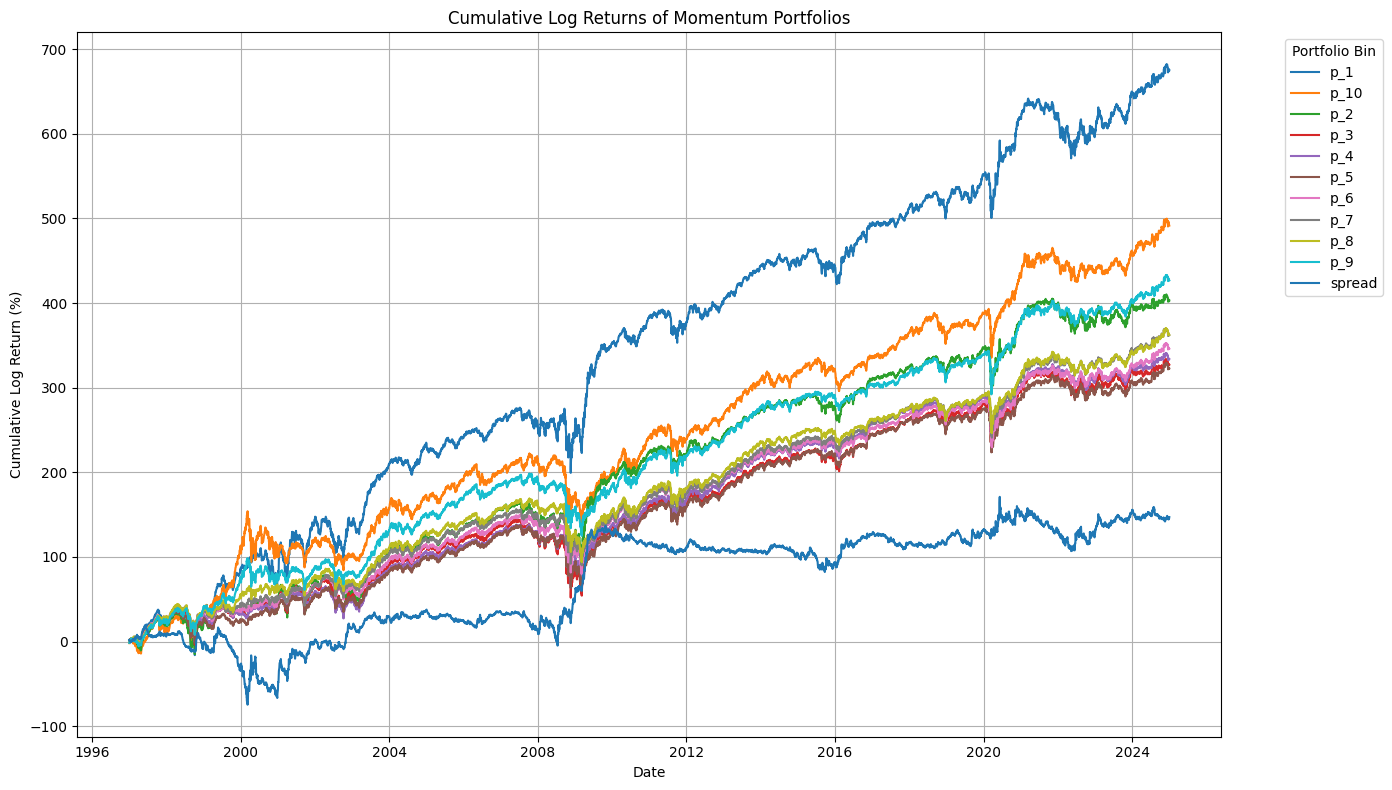

In [42]:
# TODO: Chart the cumulative log returns of each portfolio.

def plot_cumulative_returns(momentum_returns: pl.DataFrame):
    """
    Plot the cumulative log returns of each portfolio.
    
    Args:
        momentum_returns (pl.DataFrame): Data frame with columns date, bin, return, and cumulative_log_return columns.
    """
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=momentum_returns.to_pandas(), x='date', y='cumulative_log_return', hue='bin', palette='tab10')
    plt.title('Cumulative Log Returns of Momentum Portfolios')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Log Return (%)')
    plt.legend(title='Portfolio Bin', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()  
plot_cumulative_returns(momentum_returns)

In [45]:
# TODO: Create a table of summary metrics
def calculate_performance_metrics(momentum_portfolios):
    """
    Calculate annualized performance metrics for each portfolio.
    
    Args:
        momentum_portfolios (pl.DataFrame): Data frame with portfolio returns.
    
    Returns:
        pl.DataFrame: Data frame with annualized return, volatility, and Sharpe ratio for each portfolio.
    """
    # Convert to long format for calculation
    portfolio_returns = momentum_portfolios.melt(
        id_vars='date', 
        variable_name='portfolio', 
        value_name='daily_return'
    )
    
    # Calculate metrics by portfolio
    metrics = (portfolio_returns
        .group_by('portfolio')
        .agg([
            (pl.col('daily_return').mean() * 252).alias('annualized_return'),
            (pl.col('daily_return').std() * np.sqrt(252)).alias('annualized_volatility'),
            ((pl.col('daily_return').mean() / pl.col('daily_return').std()) * np.sqrt(252)).alias('sharpe_ratio')
        ])
        .sort('portfolio')
    )
    
    # Format the metrics for better presentation
    metrics = metrics.with_columns([
        pl.col('annualized_return').round(2),
        pl.col('annualized_volatility').round(2),
        pl.col('sharpe_ratio').round(2)
    ])
    
    return metrics

# Calculate performance metrics
performance_metrics = calculate_performance_metrics(momentum_portfolios)

# Display the performance metrics table
print("Performance Metrics (Annualized):")
display(performance_metrics)

Performance Metrics (Annualized):


/tmp/ipykernel_1027447/1982291266.py:13: DeprecationWarning: `DataFrame.melt` is deprecated; use `DataFrame.unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  portfolio_returns = momentum_portfolios.melt(


portfolio,annualized_return,annualized_volatility,sharpe_ratio
str,f64,f64,f64
"""p_1""",28.81,30.58,0.94
"""p_10""",21.57,28.18,0.77
"""p_2""",17.62,25.31,0.7
"""p_3""",14.33,22.94,0.62
"""p_4""",14.28,21.63,0.66
…,…,…,…
"""p_6""",14.48,20.48,0.71
"""p_7""",15.05,20.49,0.73
"""p_8""",15.19,21.08,0.72
